# Proyek Mandiri (Capstone) - Certified Data Analyst for Business

## 1. Connect Colab to Google Drive

In [37]:
# Mengkoneksikan colab dengan gdrive
from google.colab import drive
drive.mount('/content/gdrive')
import os

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
# Load the data
path = '/content/gdrive/My Drive/Colab Notebooks/sqlite/'

# Check Directory
os.listdir(path)

['rexon_metals.db',
 'weather_stations.db',
 'transportation_sales.db',
 'narasio_class.db',
 'Olist E-commerce.db']

## 2. Import Packages

In [39]:
# Import package
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import statistics

## 3. Connect SQLite to Python

In [40]:
# Kemudian kembali membuat connection ke database yang udah ada
conn = sqlite3.connect(path + 'Olist E-commerce.db')

# Membuat cursor object untuk memanggil SQL statement
cur = conn.cursor()

In [11]:
# Kemudian kita dapat execute SQL statement. Kali ini kita akan mengecek terdapat tabel apa saja di rexon_metals.db
cur.execute("""
              SELECT
                  name
              FROM sqlite_master
              WHERE type='table'
            """)

print(cur.fetchall())

[('Orders',), ('Products',), ('Customers',), ('Sellers',), ('Geolocation',)]


## 4. Data Preparation Using SQL

**JOIN TABLE**

**Join Order and Customer table**s: menggabungkan tabel Order dengan tabel Customer berdasarkan kolom customer_id yang merupakan kunci asing di tabel Order dan kunci utama di tabel Customer.

**Join Order and Product tables**: Query ini menggabungkan tabel Order dengan tabel Product berdasarkan kolom product_id yang merupakan kunci asing di tabel Order dan kunci utama di tabel Product.

**Join Customer with Geolocation (potential join**): Query ini mencoba untuk menggabungkan tabel Customer dengan tabel Geolocation berdasarkan kolom customer_zip_code_prefix yang mungkin berperan sebagai kunci luar di kedua tabel.

In [12]:
# Join Order and Customer tables
order_customer_join = """
SELECT o.*, c.*
FROM Orders o
INNER JOIN Customers c ON o.customer_id = c.customer_id;
"""

# Join Order and Product tables (assuming product_id is a foreign key)
order_product_join = """
SELECT o.*, p.*
FROM Orders o
INNER JOIN Products p ON o.product_id = p.product_id;
"""

# Join Customer with Geolocation (potential join)
customer_geolocation_join = """
SELECT c.*, g.*
FROM Customers c
LEFT JOIN Geolocation g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix;
"""


In [13]:
# Execute Order and Customer join query
cur.execute(order_customer_join)
order_customer_results = cur.fetchall()

# Execute Order and Product join query (assuming product_id is a foreign key)
cur.execute(order_product_join)
order_product_results = cur.fetchall()

# Execute Customer with Geolocation join query (potential join)
cur.execute(customer_geolocation_join)
customer_geolocation_results = cur.fetchall()

## 5. Problem Statement

1. melakukan profiling agar mendapat customer yang lebih tertarget.
2. memberikan product recommendation untuk meningkatkan revenue
3. Mengoptimalisasi penggunaan payment agar lebih tertarget pada customer.

## 6. Data Preparation Using Python (Cleansing, Manipulation, Handling Outlier dst)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

## **ORDER**

In [15]:
# Membaca data order
order = pd.read_sql_query("""
                    SELECT
                        *
                    FROM Orders
                  """, conn)
order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,delivered,2018-03-01 14:14:28,2018-03-01 15:10:47,2018-03-02 21:09:20,2018-03-12 23:36:26,2018-03-21 00:00:00,1.0,72d3bf1d3a790f8874096fcf860e3eff,...,1.0,credit_card,1.0,54.36,8f39f09c22b1ceb6e3eb178d8e50bb8a,4.0,None,Gostei do produto,2018-03-13 00:00:00,2018-03-14 10:36:16
1,641fb0752bf5b5940c376b3a8bb9dc52,f5afca14dfa9dc64251cf2b45c54c363,delivered,2017-12-15 00:06:10,2017-12-15 00:14:55,2017-12-19 01:58:00,2018-01-03 15:09:32,2018-01-16 00:00:00,1.0,60184212dae4e6b0da32bf54271a8c4a,...,1.0,credit_card,10.0,386.33,ffa0d9ba2678dba5fa370295245f473d,4.0,None,"Inicialmente, pedi o cancelamento do pedido de...",2018-01-04 00:00:00,2018-01-04 18:29:06
2,b52cc4919de82b4d696a4380d10804a3,be8c14c16a4d47194ccdfe10f1fc5b1a,delivered,2018-06-13 13:47:39,2018-06-15 02:37:29,2018-06-15 14:22:00,2018-06-18 22:32:44,2018-06-26 00:00:00,1.0,7564c1759c04fc0a38f2aa84f7a370ee,...,1.0,boleto,1.0,55.02,b1dafcdfcddb6feb75222b9c1f2baad3,5.0,None,None,2018-06-19 00:00:00,2018-06-20 11:07:14
3,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-04-24 09:34:13,2017-05-10 09:17:55,2017-05-12 00:00:00,1.0,a5a0e71a81ae65aa335e71c06261e260,...,1.0,boleto,1.0,267.80,fd793fea4f4a2ddcc956561144b6c04e,1.0,None,None,2017-05-11 00:00:00,2017-05-12 11:25:49
4,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-04-24 09:34:13,2017-05-10 09:17:55,2017-05-12 00:00:00,2.0,a5a0e71a81ae65aa335e71c06261e260,...,1.0,boleto,1.0,267.80,fd793fea4f4a2ddcc956561144b6c04e,1.0,None,None,2017-05-11 00:00:00,2017-05-12 11:25:49


In [16]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11001 entries, 0 to 11000
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       11000 non-null  object 
 1   customer_id                    11001 non-null  object 
 2   order_status                   11001 non-null  object 
 3   order_purchase_timestamp       11000 non-null  object 
 4   order_approved_at              10983 non-null  object 
 5   order_delivered_carrier_date   10802 non-null  object 
 6   order_delivered_customer_date  10685 non-null  object 
 7   order_estimated_delivery_date  11000 non-null  object 
 8   order_item_id                  10920 non-null  float64
 9   product_id                     10920 non-null  object 
 10  seller_id                      10920 non-null  object 
 11  shipping_limit_date            10920 non-null  object 
 12  price                          10920 non-null 

***Merubah Type Data***

In [17]:
# Ubah tipe data kolom tanggal menjadi datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date',
                'review_creation_date', 'review_answer_timestamp']
order[date_columns] = order[date_columns].apply(pd.to_datetime)

# Ubah tipe data kolom numerik menjadi float64
numeric_columns = ['order_item_id', 'price', 'freight_value', 'payment_sequential',
                   'payment_installments', 'payment_value', 'review_score']
order[numeric_columns] = order[numeric_columns].astype(float)

# Ubah tipe data kolom kategorikal menjadi category jika jumlah nilai uniknya terbatas
categorical_columns = ['order_id', 'customer_id', 'order_status', 'product_id', 'seller_id',
                       'payment_type', 'review_id']
for col in categorical_columns:
    if len(order[col].unique()) < len(order) * 0.5:  # Ambil persentase yang sesuai
        order[col] = order[col].astype('category')

Membuat Kolom Baru Order_date yang merupakan klonning isi data dari order_purchase_timestamp karena yang diperlukan hanya tanggal order produk, dan memimndahkan letak order_date kesebelah kiri order_estimated_delivery_date

In [18]:
#Membuat kolom baru order_date dan merubah type datanya menjadi date, karena hanya menampilkan tahun saja
order['order_date'] = pd.to_datetime(order['order_purchase_timestamp']).dt.date
# Hapus kolom yang tidak diperlukan
order.drop(columns=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date','order_delivered_customer_date','review_creation_date','review_answer_timestamp'], inplace=True)

# Mendapatkan indeks kolom order_estimated_delivery_date
columns = order.columns.tolist()
idx_order_estimated_delivery_date = columns.index('order_estimated_delivery_date')

# Pindahkan kolom order_date ke sebelah kiri order_estimated_delivery_date
columns.insert(idx_order_estimated_delivery_date, columns.pop(columns.index('order_date')))
order = order.reindex(columns=columns)
order.head()

,order_id,customer_id,order_status,order_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message
0,432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,delivered,2018-03-01,2018-03-21,1.0,72d3bf1d3a790f8874096fcf860e3eff,0bae85eb84b9fb3bd773911e89288d54,2018-03-07 15:10:47,38.25,16.11,1.0,credit_card,1.0,54.36,8f39f09c22b1ceb6e3eb178d8e50bb8a,4.0,None,Gostei do produto
1,641fb0752bf5b5940c376b3a8bb9dc52,f5afca14dfa9dc64251cf2b45c54c363,delivered,2017-12-15,2018-01-16,1.0,60184212dae4e6b0da32bf54271a8c4a,b33e7c55446eabf8fe1a42d037ac7d6d,2017-12-21 00:14:55,369.00,17.33,1.0,credit_card,10.0,386.33,ffa0d9ba2678dba5fa370295245f473d,4.0,None,"Inicialmente, pedi o cancelamento do pedido de..."
2,b52cc4919de82b4d696a4380d10804a3,be8c14c16a4d47194ccdfe10f1fc5b1a,delivered,2018-06-13,2018-06-26,1.0,7564c1759c04fc0a38f2aa84f7a370ee,6860153b69cc696d5dcfe1cdaaafcf62,2018-06-19 02:30:26,42.99,12.03,1.0,boleto,1.0,55.02,b1dafcdfcddb6feb75222b9c1f2baad3,5.0,None,None
3,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20,2017-05-12,1.0,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,1.0,boleto,1.0,267.80,fd793fea4f4a2ddcc956561144b6c04e,1.0,None,None
4,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20,2017-05-12,2.0,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,1.0,boleto,1.0,267.80,fd793fea4f4a2ddcc956561144b6c04e,1.0,None,None


***Missing Value***

In [19]:
jumlah_missing = pd.isnull(order).sum()
rasio = jumlah_missing.div(len(order))
rasio

order_id                         0.000091
customer_id                      0.000000
order_status                     0.000000
order_date                       0.000091
order_estimated_delivery_date    0.000091
order_item_id                    0.007363
product_id                       0.007363
seller_id                        0.007363
shipping_limit_date              0.007363
price                            0.007363
freight_value                    0.007363
payment_sequential               0.000273
payment_type                     0.000273
payment_installments             0.000273
payment_value                    0.000273
review_id                        0.000091
review_score                     0.000091
review_comment_title             0.882011
review_comment_message           0.569585
dtype: float64

**Dari hasil ratio diketahui bahwa review_comment_title dan review_comment_message, memiliki missing value lebih dari 50% sehingga harus dihilangkan.**

### Outlier yang lebih dari 50% (atau disebut juga sebagai **high leverage points**) seringkali dianggap sebagai titik yang tidak biasa atau tidak representatif dalam sebuah dataset. Mereka dapat memiliki pengaruh yang signifikan terhadap analisis statistik dan model yang dibangun dari data tersebut.

In [20]:
# Kolom review_comment_title memiliki jumlah missing value hingga 88% sehingga lebih baik dihilangkan (drop) dari table
order = order.drop(['review_comment_title'], axis=1)
order = order.drop(['review_comment_message'], axis=1)

Mengubah nilai NaNs dengan Mean dan menghapus nilai yang kosong

In [21]:
# Mengubah NaNs dengan nilai Mean
order['order_item_id'].fillna(int(order['order_item_id'].mean()), inplace=True)
order['payment_sequential'].fillna(int(order['payment_sequential'].mean()), inplace=True)
order['payment_installments'].fillna(int(order['payment_installments'].mean()), inplace=True)
order['review_score'].fillna(int(order['review_score'].mean()), inplace=True)
order['payment_value'].fillna(int(order['payment_value'].mean()), inplace=True)
order['order_estimated_delivery_date'].fillna(order['order_estimated_delivery_date'].mean(), inplace=True)

# Hapus baris dengan missing value dari kolom review_id, review_score, review_creation_date, dan review_answer_timestamp
order.dropna(subset=['review_id','product_id','seller_id','shipping_limit_date','price','freight_value','product_id','order_id', 'review_score', 'payment_type'], inplace=True)
order.isnull().any()

order_id                         False
customer_id                      False
order_status                     False
order_date                       False
order_estimated_delivery_date    False
order_item_id                    False
product_id                       False
seller_id                        False
shipping_limit_date              False
price                            False
freight_value                    False
payment_sequential               False
payment_type                     False
payment_installments             False
payment_value                    False
review_id                        False
review_score                     False
dtype: bool

***Duplicate***

In [22]:
# Mengidentifikasi apakah terdapat duplicate value pada tabel dengan acuan kolom PassengerId
order[order["order_id"].duplicated(keep=False)].sort_values("order_id")

,order_id,customer_id,order_status,order_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score
2124,00526a9d4ebde463baee25f386963ddc,5848ef3f994e18c5121d291e0daedc81,delivered,2018-08-07,2018-08-15,4.0,0c4a0f8ab44f9acd2d04e7024f9ba362,7210cd29727d674c00741e5e387b3ccd,2018-08-14 22:15:22,33.89,8.40,1.0,credit_card,3.0,169.16,143f6db7fc05f38965da560ef1c44ed3,1.0
2123,00526a9d4ebde463baee25f386963ddc,5848ef3f994e18c5121d291e0daedc81,delivered,2018-08-07,2018-08-15,3.0,0c4a0f8ab44f9acd2d04e7024f9ba362,7210cd29727d674c00741e5e387b3ccd,2018-08-14 22:15:22,33.89,8.40,1.0,credit_card,3.0,169.16,143f6db7fc05f38965da560ef1c44ed3,1.0
5230,00c405bd71187154a7846862f585a9d4,1ab52508d3c58d96241850142347b75f,delivered,2017-10-23,2017-11-17,1.0,c4cf7c2e1f190d51517eba7e8211c8e6,f3295428338a40977a03f555246a70f4,2017-10-27 15:14:13,29.90,16.79,4.0,voucher,1.0,0.25,4f611351fcbae81bdd205a9d1365e6cb,1.0
5229,00c405bd71187154a7846862f585a9d4,1ab52508d3c58d96241850142347b75f,delivered,2017-10-23,2017-11-17,1.0,c4cf7c2e1f190d51517eba7e8211c8e6,f3295428338a40977a03f555246a70f4,2017-10-27 15:14:13,29.90,16.79,1.0,credit_card,1.0,6.03,4f611351fcbae81bdd205a9d1365e6cb,1.0
2032,011bf86f1b7dacebda2c874333cf656b,e1238987433fd511c3a493ea3d3913b0,delivered,2018-03-09,2018-04-05,2.0,9ecadb84c81da840dbf3564378b586e9,1025f0e2d44d7041d6cf58b6550e0bfa,2018-03-16 19:48:24,35.00,19.32,1.0,credit_card,10.0,108.64,1e62f9d5cf5ccb955bfee492ab431d59,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,ff1f8f328e5a59ac754240b6dd31bcb4,ba53e87622e90e0a905d871c0c8d53af,delivered,2017-08-10,2017-08-30,1.0,e7a6f33d382bca6fa19f52ff13e440bd,4a3ca9315b744ce9f8e9374361493884,2017-08-16 16:25:17,74.00,12.02,3.0,voucher,1.0,142.58,f19a2dbaf07596ee336198c33d3b6d13,5.0
2744,ff1f8f328e5a59ac754240b6dd31bcb4,ba53e87622e90e0a905d871c0c8d53af,delivered,2017-08-10,2017-08-30,3.0,e7a6f33d382bca6fa19f52ff13e440bd,4a3ca9315b744ce9f8e9374361493884,2017-08-16 16:25:17,74.00,12.02,3.0,voucher,1.0,142.58,f19a2dbaf07596ee336198c33d3b6d13,5.0
3398,ff978de32e717acd3b5abe1fb069d2b6,82808ea6794ed5643bd23f65508aed70,delivered,2017-12-12,2018-01-31,1.0,0829c25b4a3efca7651f07cd4b8e05bc,9f505651f4a6abe901a56cdc21508025,2017-12-18 09:57:24,27.99,21.15,1.0,voucher,1.0,30.00,b4329e8ea138094db0568b16dca9c99b,5.0
3397,ff978de32e717acd3b5abe1fb069d2b6,82808ea6794ed5643bd23f65508aed70,delivered,2017-12-12,2018-01-31,1.0,0829c25b4a3efca7651f07cd4b8e05bc,9f505651f4a6abe901a56cdc21508025,2017-12-18 09:57:24,27.99,21.15,2.0,voucher,1.0,10.80,b4329e8ea138094db0568b16dca9c99b,5.0


In [23]:
#Hapus Duplicate
order = order.drop_duplicates(subset=['order_id']).reset_index()
# Cek kembali apakah masih ada data duplicate
order[order.order_id.duplicated(keep=False)].sort_values("order_id")

,index,order_id,customer_id,order_status,order_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score


## ***Order Outlier***

In [24]:
order.describe()

,index,order_estimated_delivery_date,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score
count,10642.000000,10642,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000
mean,5497.984589,2018-01-24 21:27:38.259725568,1.151757,120.114805,20.093013,1.069066,2.968897,168.599322,4.040218
min,0.000000,2016-10-28 00:00:00,1.000000,1.200000,0.000000,1.000000,1.000000,0.030000,1.000000
25%,2746.250000,2017-10-04 00:00:00,1.000000,39.900000,13.150000,1.000000,1.000000,60.690000,4.000000
50%,5506.500000,2018-02-16 00:00:00,1.000000,75.000000,16.320000,1.000000,2.000000,107.875000,5.000000
75%,8246.750000,2018-05-25 00:00:00,1.000000,130.000000,21.397500,1.000000,4.000000,187.250000,5.000000
max,11000.000000,2018-10-25 00:00:00,14.000000,4399.870000,255.920000,29.000000,24.000000,13664.080000,5.000000
std,3176.698078,NaN,0.539390,176.529480,15.348891,0.544792,2.773753,266.032734,1.380615


*Deteksi Outlier dengan menggunakan metode IQR*

In [25]:
def detect_outliers_iqr(df):
    q1 = np.percentile(df, 25)
    q3 = np.percentile(df, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [x for x in df if x < lower_bound or x > upper_bound]
    return outliers

In [26]:
# Deteksi outlier dengan IQR
order_item_id_outliers = detect_outliers_iqr(list(order.order_item_id))
print("Outliers from IQR method: ", order_item_id_outliers)

# Deteksi outlier dengan IQR
price_outliers = detect_outliers_iqr(list(order.price))
print("Outliers from IQR method: ", price_outliers)

# Deteksi outlier dengan IQR
freight_value_outliers = detect_outliers_iqr(list(order.freight_value))
print("Outliers from IQR method: ", freight_value_outliers)

# Deteksi outlier dengan IQR
payment_sequential_outliers = detect_outliers_iqr(list(order.payment_sequential))
print("Outliers from IQR method: ", payment_sequential_outliers)

# Deteksi outlier dengan IQR
payment_installments_outliers = detect_outliers_iqr(list(order.payment_installments))
print("Outliers from IQR method: ", payment_installments_outliers)

# Deteksi outlier dengan IQR
payment_value_outliers = detect_outliers_iqr(list(order.payment_value))
print("Outliers from IQR method: ", payment_value_outliers)

# Deteksi outlier dengan IQR
review_score_outliers = detect_outliers_iqr(list(order.review_score))
print("Outliers from IQR method: ", review_score_outliers)

Outliers from IQR method:  [2.0, 2.0, 4.0, 5.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 6.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 3.0, 6.0, 2.0, 2.0, 3.0, 2.0, 3.0, 2.0, 2.0, 2.0, 4.0, 6.0, 2.0, 2.0, 6.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 3.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 6.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 3.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0, 4.0, 4.0, 3.0, 4.0, 2.0, 2.0, 3.0, 3.0, 2.0, 10.0, 2.0, 2.0, 2.0, 2

**order_item_id**

In [27]:
q1 = order['order_item_id'].quantile(0.25)
q3 = order['order_item_id'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
p = []
for k in range(len(order['order_item_id'])):
    if order['order_item_id'].iloc[k] < lower_bound:
        order.loc[k, 'order_item_id'] = lower_bound
    elif order['order_item_id'].iloc[k] > upper_bound:
        order.loc[k, 'order_item_id'] = upper_bound
    p.append(k)
print("New sample:",p)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

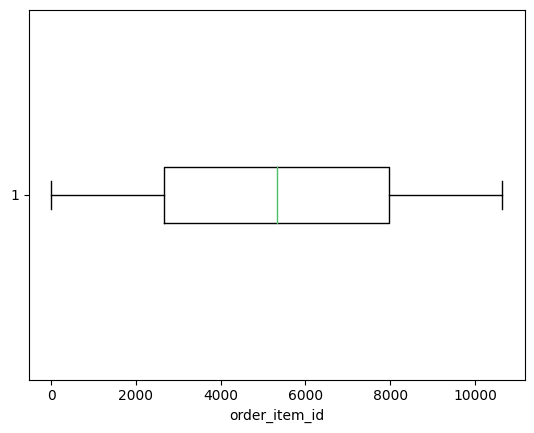

In [28]:
# Membuat boxplot
plt.boxplot(p, vert=False)
sns.set_palette("viridis_r")
plt.xlabel('order_item_id')
plt.show()

**price**

In [29]:
q1 = order['price'].quantile(0.25)
q3 = order['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
a = []
for k in range(len(order['price'])):
    if order['price'].iloc[k] < lower_bound:
        order.loc[k, 'price'] = lower_bound
    elif order['price'].iloc[k] > upper_bound:
        order.loc[k, 'price'] = upper_bound
    a.append(k)
print("New sample:",a)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

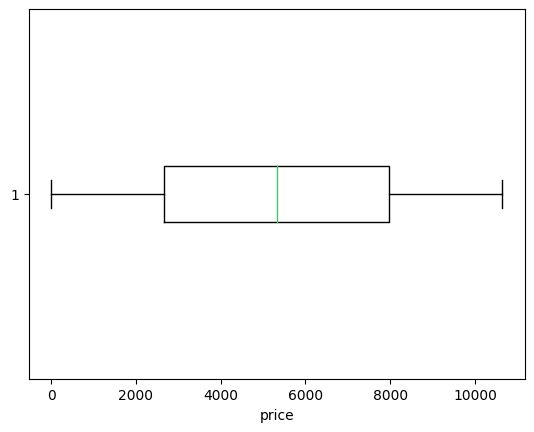

In [30]:
# Membuat boxplot
plt.boxplot(a, vert=False)
sns.set_palette("viridis_r")
plt.xlabel('price')
plt.show()

***freight_value***

In [31]:
q1 = order['freight_value'].quantile(0.25)
q3 = order['freight_value'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
a = []
for k in range(len(order['freight_value'])):
    if order['freight_value'].iloc[k] < lower_bound:
        order.loc[k, 'freight_value'] = lower_bound
    elif order['freight_value'].iloc[k] > upper_bound:
        order.loc[k, 'freight_value'] = upper_bound
    a.append(k)
print("New sample:",a)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

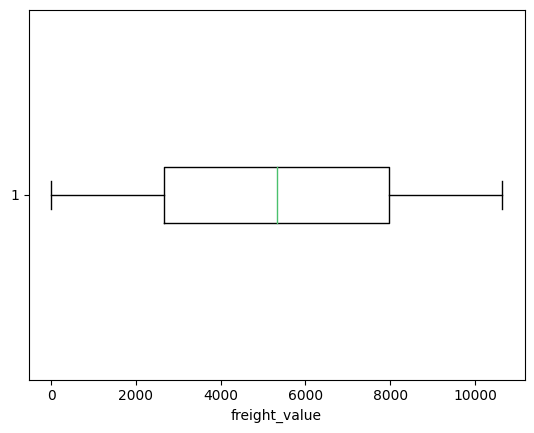

In [32]:
# Membuat boxplot
plt.boxplot(a, vert=False)
sns.set_palette("viridis_r")
plt.xlabel('freight_value')
plt.show()

**payment_sequential**

In [33]:
q1 = order['payment_sequential'].quantile(0.25)
q3 = order['payment_sequential'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
a = []
for k in range(len(order['payment_sequential'])):
    if order['payment_sequential'].iloc[k] < lower_bound:
        order.loc[k, 'payment_sequential'] = lower_bound
    elif order['payment_sequential'].iloc[k] > upper_bound:
        order.loc[k, 'payment_sequential'] = upper_bound
    a.append(k)
print("New sample:",a)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

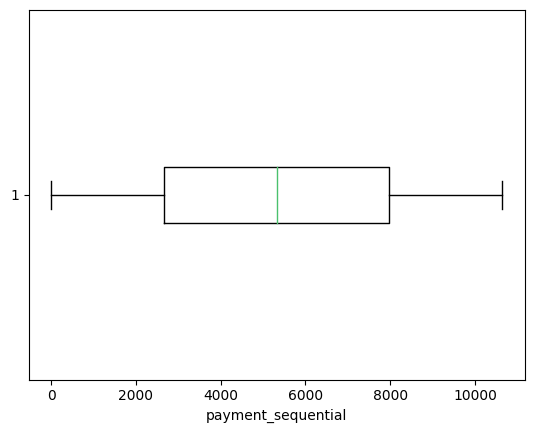

In [34]:
# Membuat boxplot
plt.boxplot(a, vert=False)
sns.set_palette("viridis_r")
plt.xlabel('payment_sequential')
plt.show()

**payment_installments**

In [35]:
q1 = order['payment_installments'].quantile(0.25)
q3 = order['payment_installments'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
a = []
for k in range(len(order['payment_installments'])):
    if order['payment_installments'].iloc[k] < lower_bound:
        order.loc[k, 'payment_installments'] = lower_bound
    elif order['payment_installments'].iloc[k] > upper_bound:
        order.loc[k, 'payment_installments'] = upper_bound
    a.append(k)
print("New sample:",a)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

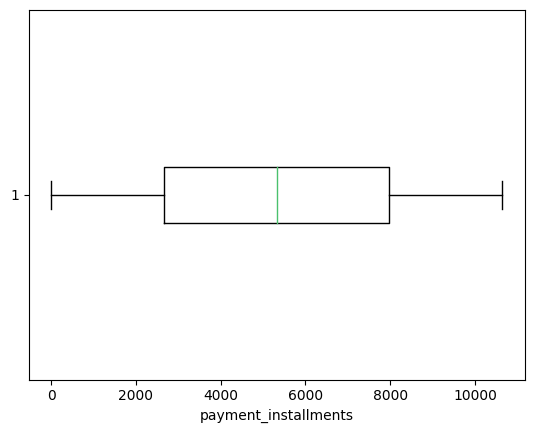

In [36]:
# Membuat boxplot
plt.boxplot(a, vert=False)
sns.set_palette("viridis_r")
plt.xlabel('payment_installments')
plt.show()

**payment_value**

In [41]:
q1 = order['payment_value'].quantile(0.25)
q3 = order['payment_value'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
b = []
for k in range(len(order['payment_value'])):
    if order['payment_value'].iloc[k] < lower_bound:
        order.loc[k, 'payment_value'] = lower_bound
    elif order['payment_value'].iloc[k] > upper_bound:
        order.loc[k, 'payment_value'] = upper_bound
    b.append(k)
print("New sample:",b)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

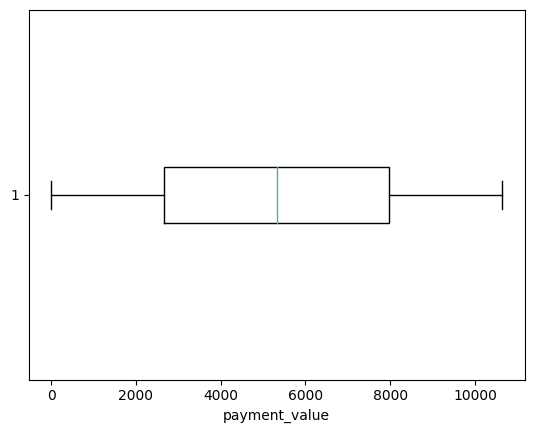

In [42]:
# Membuat boxplot
plt.boxplot(b, vert=False)
sns.set_palette("viridis_r")
plt.xlabel('payment_value')
plt.show()

**review_score**

In [43]:
q1 = order['review_score'].quantile(0.25)
q3 = order['review_score'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
c = []
for k in range(len(order['review_score'])):
    if order['review_score'].iloc[k] < lower_bound:
        order.loc[k, 'review_score'] = lower_bound
    elif order['review_score'].iloc[k] > upper_bound:
        order.loc[k, 'review_score'] = upper_bound
    c.append(k)
print("New sample:",c)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

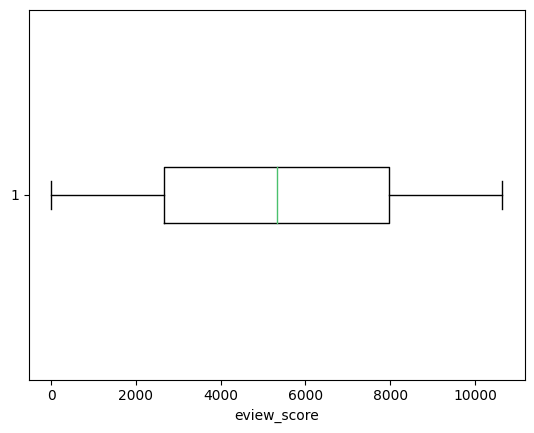

In [44]:
# Membuat boxplot
plt.boxplot(c, vert=False)
sns.set_palette("viridis_r")
plt.xlabel('eview_score')
plt.show()

# ***Products***

In [45]:
# mendapatkan data product
produk = pd.read_sql_query("""
                    SELECT
                        *
                    FROM Products
                  """, conn)
produk.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,72d3bf1d3a790f8874096fcf860e3eff,toys,57.0,341.0,2.0,583.0,20.0,21.0,20.0
1,60184212dae4e6b0da32bf54271a8c4a,watches_gifts,59.0,476.0,2.0,394.0,17.0,11.0,14.0
2,7564c1759c04fc0a38f2aa84f7a370ee,construction_tools_construction,59.0,2432.0,3.0,1200.0,16.0,11.0,11.0
3,a5a0e71a81ae65aa335e71c06261e260,housewares,57.0,698.0,3.0,705.0,34.0,22.0,28.0
4,69d980b4120a76616d7b237d731d6156,watches_gifts,60.0,1362.0,3.0,600.0,16.0,11.0,12.0


In [46]:
produk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  7023 non-null   object 
 1   product_category_name       6899 non-null   object 
 2   product_name_lenght         6902 non-null   float64
 3   product_description_lenght  6902 non-null   float64
 4   product_photos_qty          6902 non-null   float64
 5   product_weight_g            7021 non-null   float64
 6   product_length_cm           7021 non-null   float64
 7   product_height_cm           7021 non-null   float64
 8   product_width_cm            7021 non-null   float64
dtypes: float64(7), object(2)
memory usage: 493.9+ KB


**MEngubah Type Dtaa**

In [47]:
# Ubah tipe data kolom menjadi kategori
produk['product_category_name'] = produk['product_category_name'].astype('category')

**Missing Vlue**

In [48]:
# Cek kembali apakah masih terdapat missing value
pd.isnull(produk).sum()

product_id                      0
product_category_name         124
product_name_lenght           121
product_description_lenght    121
product_photos_qty            121
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [49]:
# Hitung mode dari kolom product_category_name
mode_value = produk['product_category_name'].mode()[0]

# Ganti missing value dengan mode
produk['product_category_name'].fillna(mode_value, inplace=True)


In [51]:
# Mengubah NaNs dengan nilai Mean
produk['product_name_lenght'].fillna(int(produk['product_name_lenght'].mean()), inplace=True)
produk['product_description_lenght'].fillna(int(produk['product_description_lenght'].mean()), inplace=True)
produk['product_photos_qty'].fillna(int(produk['product_photos_qty'].mean()), inplace=True)
produk['product_weight_g'].fillna(int(produk['product_weight_g'].mean()), inplace=True)
produk['product_length_cm'].fillna(int(produk['product_length_cm'].mean()), inplace=True)
produk['product_height_cm'].fillna(produk['product_height_cm'].mean(), inplace=True)
produk['product_width_cm'].fillna(produk['product_width_cm'].mean(), inplace=True)
produk.isnull().any()

product_id                    False
product_category_name         False
product_name_lenght           False
product_description_lenght    False
product_photos_qty            False
product_weight_g              False
product_length_cm             False
product_height_cm             False
product_width_cm              False
dtype: bool

**Duplicate**

In [52]:
# Cek kembali apakah masih ada data duplicate
produk[produk.product_id.duplicated(keep=False)].sort_values("product_id")

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


# ***Produk Outlier***

In [53]:
produk.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,7023.000000,7023.000000,7023.000000,7023.000000,7023.000000,7023.000000,7023.000000
mean,48.822156,788.349850,2.224263,2169.125445,30.631924,16.704031,22.974647
std,10.054755,647.328907,1.734343,4036.707357,16.565800,13.714637,11.809025
min,9.000000,4.000000,1.000000,50.000000,7.000000,2.000000,8.000000
25%,43.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,612.000000,2.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,982.500000,3.000000,1850.000000,38.000000,20.000000,30.000000
max,76.000000,3949.000000,17.000000,30000.000000,105.000000,105.000000,118.000000


In [54]:
# Deteksi outlier dengan IQR df_produk
product_name_lenght_outliers = detect_outliers_iqr(list(produk.product_name_lenght))
print("Outliers product_name_lenght from IQR method: ", product_name_lenght_outliers)

Outliers product_name_lenght from IQR method:  [20.0, 18.0, 12.0, 20.0, 21.0, 21.0, 21.0, 18.0, 20.0, 15.0, 12.0, 20.0, 21.0, 20.0, 19.0, 20.0, 20.0, 16.0, 21.0, 21.0, 19.0, 16.0, 20.0, 15.0, 21.0, 21.0, 16.0, 9.0, 16.0, 21.0, 17.0, 20.0, 12.0, 19.0, 16.0, 20.0, 16.0, 19.0, 14.0, 21.0, 21.0, 21.0, 13.0, 19.0, 16.0, 19.0, 15.0, 21.0, 19.0, 21.0, 15.0, 20.0, 15.0, 20.0, 21.0, 9.0, 20.0, 21.0, 21.0, 16.0, 21.0, 18.0, 20.0, 18.0, 19.0, 19.0, 20.0, 12.0, 18.0, 18.0, 21.0, 18.0, 19.0, 21.0, 20.0, 20.0, 18.0, 20.0, 20.0, 19.0, 21.0, 14.0, 12.0, 14.0, 21.0, 19.0, 21.0, 21.0, 12.0, 15.0, 17.0, 21.0, 19.0, 16.0, 13.0, 13.0, 20.0, 21.0, 21.0, 18.0, 19.0, 20.0]


In [55]:
# Deteksi outlier dengan IQR df_produk
product_description_lenght_outliers = detect_outliers_iqr(list(produk.product_description_lenght))
print("Outliers product_name_lenght from IQR method: ", product_description_lenght_outliers)

Outliers product_name_lenght from IQR method:  [2432.0, 2013.0, 2805.0, 2361.0, 2310.0, 2574.0, 2167.0, 2660.0, 2178.0, 2395.0, 1936.0, 3035.0, 2032.0, 2792.0, 2876.0, 2460.0, 2083.0, 2085.0, 1936.0, 2453.0, 2411.0, 2108.0, 3913.0, 3876.0, 3329.0, 2164.0, 2376.0, 2981.0, 2213.0, 3557.0, 2323.0, 2010.0, 2101.0, 2188.0, 2566.0, 2093.0, 2243.0, 2993.0, 2081.0, 3006.0, 2223.0, 2904.0, 2115.0, 3530.0, 2242.0, 2299.0, 2922.0, 2138.0, 2010.0, 2324.0, 2136.0, 2985.0, 2285.0, 1996.0, 1940.0, 3708.0, 2043.0, 2058.0, 1977.0, 2053.0, 3136.0, 3037.0, 3231.0, 2165.0, 2396.0, 2718.0, 2127.0, 3207.0, 2356.0, 2235.0, 2010.0, 2331.0, 2690.0, 2219.0, 3161.0, 2950.0, 2154.0, 2873.0, 2083.0, 3319.0, 3847.0, 2253.0, 2113.0, 2001.0, 2724.0, 2273.0, 2438.0, 2073.0, 3894.0, 2213.0, 3758.0, 2089.0, 3530.0, 2910.0, 2440.0, 2894.0, 2493.0, 2010.0, 2017.0, 1996.0, 2395.0, 2335.0, 2352.0, 1953.0, 3734.0, 2345.0, 1972.0, 3139.0, 2231.0, 2361.0, 2047.0, 3194.0, 3060.0, 2558.0, 2936.0, 2084.0, 2473.0, 2526.0, 3490.0, 

In [56]:
# Deteksi outlier dengan IQR df_produk
product_photos_qty_outliers = detect_outliers_iqr(list(produk.product_photos_qty))
print("Outliers product_name_lenght from IQR method: ", product_photos_qty_outliers)

Outliers product_name_lenght from IQR method:  [9.0, 7.0, 13.0, 8.0, 8.0, 8.0, 8.0, 7.0, 8.0, 7.0, 7.0, 7.0, 12.0, 7.0, 10.0, 7.0, 9.0, 7.0, 8.0, 8.0, 7.0, 8.0, 7.0, 11.0, 11.0, 7.0, 10.0, 7.0, 7.0, 7.0, 8.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 7.0, 8.0, 8.0, 7.0, 7.0, 7.0, 7.0, 8.0, 9.0, 8.0, 12.0, 7.0, 8.0, 7.0, 8.0, 10.0, 7.0, 8.0, 7.0, 7.0, 8.0, 9.0, 9.0, 9.0, 7.0, 7.0, 10.0, 9.0, 8.0, 9.0, 9.0, 9.0, 8.0, 7.0, 10.0, 7.0, 10.0, 9.0, 8.0, 7.0, 8.0, 8.0, 7.0, 8.0, 8.0, 10.0, 8.0, 9.0, 7.0, 10.0, 7.0, 7.0, 9.0, 12.0, 9.0, 9.0, 8.0, 7.0, 9.0, 10.0, 7.0, 10.0, 7.0, 10.0, 7.0, 9.0, 10.0, 7.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 7.0, 7.0, 7.0, 7.0, 10.0, 7.0, 7.0, 7.0, 8.0, 7.0, 8.0, 7.0, 15.0, 7.0, 7.0, 8.0, 9.0, 9.0, 9.0, 8.0, 12.0, 9.0, 8.0, 8.0, 10.0, 8.0, 8.0, 10.0, 7.0, 7.0, 7.0, 13.0, 11.0, 7.0, 9.0, 10.0, 7.0, 7.0, 8.0, 7.0, 8.0, 7.0, 7.0, 7.0, 7.0, 7.0, 9.0, 9.0, 9.0, 9.0, 8.0, 10.0, 8.0, 11.0, 9.0, 10.0, 8.0, 7.0, 7.0, 7.0, 11.0, 7.0, 7.0, 9.0, 10.0, 7.0, 8.0, 8.0, 7.0, 7.0, 9.0, 11.0, 9.0, 

In [57]:
# Deteksi outlier dengan IQR df_produk
product_weight_g_outliers = detect_outliers_iqr(list(produk.product_weight_g))
print("Outliers product_name_lenght from IQR method: ", product_weight_g_outliers)

Outliers product_name_lenght from IQR method:  [10700.0, 6200.0, 9400.0, 30000.0, 5500.0, 11100.0, 9050.0, 9050.0, 7600.0, 8600.0, 18800.0, 5600.0, 10900.0, 8950.0, 10600.0, 9750.0, 7600.0, 8325.0, 4450.0, 12250.0, 5850.0, 16100.0, 5500.0, 7500.0, 5200.0, 9350.0, 17600.0, 22800.0, 4450.0, 14550.0, 14150.0, 5200.0, 5900.0, 5967.0, 15350.0, 4250.0, 30000.0, 6300.0, 8050.0, 21600.0, 12000.0, 17550.0, 4550.0, 10250.0, 8100.0, 16800.0, 7850.0, 5100.0, 13250.0, 28750.0, 7000.0, 4550.0, 4375.0, 7650.0, 6663.0, 20100.0, 10975.0, 9000.0, 10850.0, 6050.0, 7000.0, 11875.0, 11350.0, 16400.0, 20700.0, 30000.0, 8050.0, 17050.0, 8400.0, 4338.0, 4463.0, 28300.0, 12650.0, 6550.0, 11800.0, 13400.0, 13950.0, 15267.0, 5950.0, 11850.0, 16550.0, 4350.0, 4200.0, 7480.0, 6050.0, 6900.0, 4650.0, 16850.0, 7625.0, 5850.0, 12300.0, 4800.0, 5550.0, 6050.0, 8900.0, 5300.0, 7550.0, 16133.0, 8500.0, 10200.0, 13300.0, 5100.0, 14300.0, 6267.0, 4800.0, 6050.0, 24800.0, 4200.0, 12250.0, 9850.0, 21300.0, 8050.0, 10750.0, 

In [58]:
# Deteksi outlier dengan IQR df_produk
product_length_cm_outliers = detect_outliers_iqr(list(produk.product_length_cm))
print("Outliers product_name_lenght from IQR method: ", product_length_cm_outliers)

Outliers product_name_lenght from IQR method:  [75.0, 105.0, 90.0, 85.0, 81.0, 90.0, 100.0, 80.0, 90.0, 73.0, 69.0, 100.0, 69.0, 69.0, 69.0, 69.0, 84.0, 70.0, 69.0, 100.0, 103.0, 98.0, 100.0, 101.0, 90.0, 69.0, 103.0, 103.0, 71.0, 105.0, 100.0, 105.0, 105.0, 90.0, 69.0, 84.0, 105.0, 105.0, 69.0, 69.0, 69.0, 100.0, 90.0, 100.0, 70.0, 69.0, 70.0, 73.0, 69.0, 74.0, 80.0, 70.0, 100.0, 100.0, 70.0, 100.0, 69.0, 95.0, 69.0, 100.0, 69.0, 69.0, 90.0, 69.0, 82.0, 89.0, 81.0, 70.0, 100.0, 69.0, 105.0, 80.0, 69.0, 85.0, 70.0, 71.0, 69.0, 91.0, 99.0, 69.0, 100.0, 86.0, 100.0, 80.0, 80.0, 90.0, 70.0, 77.0, 76.0, 91.0, 105.0, 70.0, 75.0, 70.0, 70.0, 100.0, 80.0, 80.0, 80.0, 75.0, 105.0, 69.0, 100.0, 80.0, 70.0, 81.0, 69.0, 104.0, 81.0, 80.0, 95.0, 86.0, 78.0, 80.0, 80.0, 75.0, 90.0, 70.0, 69.0, 92.0, 95.0, 100.0, 100.0, 69.0, 85.0, 95.0, 75.0, 70.0, 76.0, 80.0, 100.0, 69.0, 69.0, 100.0, 101.0, 100.0, 105.0, 99.0, 86.0, 93.0, 86.0, 93.0, 70.0, 69.0, 70.0, 71.0, 84.0, 69.0, 80.0, 93.0, 69.0, 69.0, 70.

In [59]:
# Deteksi outlier dengan IQR df_produk
product_height_cm_outliers = detect_outliers_iqr(list(produk.product_height_cm))
print("Outliers product_name_lenght from IQR method: ", product_height_cm_outliers)

Outliers product_name_lenght from IQR method:  [40.0, 75.0, 50.0, 40.0, 45.0, 40.0, 50.0, 46.0, 65.0, 45.0, 55.0, 50.0, 51.0, 40.0, 50.0, 40.0, 45.0, 105.0, 45.0, 60.0, 40.0, 52.0, 42.0, 45.0, 50.0, 50.0, 62.0, 40.0, 62.0, 50.0, 47.0, 50.0, 48.0, 54.0, 61.0, 51.0, 55.0, 48.0, 40.0, 45.0, 48.0, 42.0, 62.0, 46.0, 42.0, 60.0, 48.0, 55.0, 40.0, 40.0, 63.0, 88.0, 49.0, 44.0, 59.0, 64.0, 56.0, 45.0, 40.0, 59.0, 45.0, 96.0, 40.0, 52.0, 47.0, 47.0, 55.0, 43.0, 62.0, 74.0, 64.0, 51.0, 47.0, 52.0, 50.0, 52.0, 60.0, 64.0, 49.0, 64.0, 80.0, 45.0, 40.0, 60.0, 44.0, 60.0, 51.0, 40.0, 43.0, 55.0, 43.0, 58.0, 51.0, 39.0, 52.0, 105.0, 78.0, 75.0, 65.0, 105.0, 43.0, 40.0, 58.0, 44.0, 59.0, 52.0, 39.0, 46.0, 90.0, 52.0, 40.0, 51.0, 53.0, 56.0, 39.0, 40.0, 73.0, 49.0, 55.0, 62.0, 45.0, 44.0, 51.0, 75.0, 52.0, 45.0, 52.0, 44.0, 75.0, 98.0, 65.0, 103.0, 50.0, 44.0, 44.0, 40.0, 95.0, 47.0, 49.0, 61.0, 51.0, 89.0, 61.0, 40.0, 48.0, 60.0, 40.0, 44.0, 40.0, 47.0, 40.0, 55.0, 55.0, 60.0, 63.0, 54.0, 52.0, 49.0, 

In [60]:
# Deteksi outlier dengan IQR df_produk
product_width_cm_outliers = detect_outliers_iqr(list(produk.product_width_cm))
print("Outliers product_name_lenght from IQR method: ", product_width_cm_outliers)

Outliers product_name_lenght from IQR method:  [67.0, 56.0, 70.0, 92.0, 70.0, 55.0, 53.0, 60.0, 75.0, 55.0, 60.0, 58.0, 58.0, 74.0, 58.0, 54.0, 61.0, 60.0, 60.0, 64.0, 58.0, 90.0, 53.0, 65.0, 60.0, 80.0, 55.0, 70.0, 56.0, 60.0, 56.0, 60.0, 58.0, 61.0, 55.0, 60.0, 56.0, 82.0, 60.0, 60.0, 92.0, 82.0, 65.0, 57.0, 55.0, 55.0, 58.0, 68.0, 60.0, 53.0, 83.0, 71.0, 61.0, 60.0, 71.0, 77.0, 60.0, 60.0, 55.0, 63.0, 65.0, 55.0, 60.0, 70.0, 65.0, 60.0, 53.0, 80.0, 58.0, 61.0, 60.0, 55.0, 60.0, 67.0, 55.0, 53.0, 70.0, 58.0, 53.0, 61.0, 58.0, 62.0, 58.0, 105.0, 55.0, 93.0, 60.0, 69.0, 58.0, 56.0, 55.0, 56.0, 56.0, 67.0, 65.0, 93.0, 71.0, 60.0, 53.0, 60.0, 92.0, 64.0, 62.0, 60.0, 63.0, 70.0, 65.0, 57.0, 58.0, 65.0, 53.0, 84.0, 63.0, 58.0, 53.0, 60.0, 70.0, 61.0, 60.0, 60.0, 60.0, 63.0, 60.0, 61.0, 74.0, 55.0, 70.0, 55.0, 55.0, 54.0, 70.0, 72.0, 100.0, 55.0, 56.0, 53.0, 56.0, 56.0, 58.0, 53.0, 92.0, 79.0, 60.0, 70.0, 69.0, 60.0, 90.0, 60.0, 55.0, 63.0, 60.0, 70.0, 91.0, 60.0, 57.0, 60.0, 68.0, 55.0, 55

**product_name_lenght**

In [61]:
q1 = produk['product_name_lenght'].quantile(0.25)
q3 = produk['product_name_lenght'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
c = []
for k in range(len(produk['product_name_lenght'])):
    if produk['product_name_lenght'].iloc[k] < lower_bound:
        produk.loc[k, 'product_name_lenght'] = lower_bound
    elif produk['product_name_lenght'].iloc[k] > upper_bound:
        produk.loc[k, 'product_name_lenght'] = upper_bound
    c.append(k)
print("New sample:",c)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

**product_description_lenght**

In [62]:
q1 = produk['product_description_lenght'].quantile(0.25)
q3 = produk['product_description_lenght'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
c = []
for k in range(len(produk['product_description_lenght'])):
    if produk['product_description_lenght'].iloc[k] < lower_bound:
        produk.loc[k, 'product_description_lenght'] = lower_bound
    elif produk['product_description_lenght'].iloc[k] > upper_bound:
        produk.loc[k, 'product_description_lenght'] = upper_bound
    c.append(k)
print("New sample:",c)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

**product_photos_qty**

In [63]:
q1 = produk['product_photos_qty'].quantile(0.25)
q3 = produk['product_photos_qty'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
c = []
for k in range(len(produk['product_photos_qty'])):
    if produk['product_photos_qty'].iloc[k] < lower_bound:
        produk.loc[k, 'product_photos_qty'] = lower_bound
    elif produk['product_photos_qty'].iloc[k] > upper_bound:
        produk.loc[k, 'product_photos_qty'] = upper_bound
    c.append(k)
print("New sample:",c)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

**product_weight_g**

In [64]:
q1 = produk['product_weight_g'].quantile(0.25)
q3 = produk['product_weight_g'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
c = []
for k in range(len(produk['product_weight_g'])):
    if produk['product_weight_g'].iloc[k] < lower_bound:
        produk.loc[k, 'product_weight_g'] = lower_bound
    elif produk['product_weight_g'].iloc[k] > upper_bound:
        produk.loc[k, 'product_weight_g'] = upper_bound
    c.append(k)
print("New sample:",c)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

**product_length_cm**

In [65]:
q1 = produk['product_length_cm'].quantile(0.25)
q3 = produk['product_length_cm'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
payment_sequential_outliers = []
for k in range(len(produk['product_length_cm'])):
    if produk['product_length_cm'].iloc[k] < lower_bound:
        produk.loc[k, 'product_length_cm'] = lower_bound
    elif produk['product_length_cm'].iloc[k] > upper_bound:
        produk.loc[k, 'product_length_cm'] = upper_bound
    p.append(k)
print("New sample:",p)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

**product_height_cm**

In [66]:
q1 = produk['product_height_cm'].quantile(0.25)
q3 = produk['product_height_cm'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
payment_sequential_outliers = []
for k in range(len(produk['product_height_cm'])):
    if produk['product_height_cm'].iloc[k] < lower_bound:
        produk.loc[k, 'product_height_cm'] = lower_bound
    elif produk['product_height_cm'].iloc[k] > upper_bound:
        produk.loc[k, 'product_height_cm'] = upper_bound
    p.append(k)
print("New sample:",p)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

**product_width_cm**

In [67]:
q1 = produk['product_width_cm'].quantile(0.25)
q3 = produk['product_width_cm'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Melakukan penggantian nilai yang berada di luar batas bawah dan batas atas
payment_sequential_outliers = []
for k in range(len(produk['product_width_cm'])):
    if produk['product_width_cm'].iloc[k] < lower_bound:
        produk.loc[k, 'product_width_cm'] = lower_bound
    elif produk['product_width_cm'].iloc[k] > upper_bound:
        produk.loc[k, 'product_width_cm'] = upper_bound
    p.append(k)
print("New sample:",p)

New sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

# ***Customers***

In [68]:
# mendapatkan data customer
customer = pd.read_sql_query("""
                    SELECT
                        *
                    FROM Customers
                  """, conn)
customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,3df704f53d3f1d4818840b34ec672a9f,04cf8185c71090d28baa4407b2e6d600,5271,sao paulo,SP
1,f5afca14dfa9dc64251cf2b45c54c363,38cad70d154a4dcc42b598d5c01f7ef1,25211,duque de caxias,RJ
2,be8c14c16a4d47194ccdfe10f1fc5b1a,c86a25b8f5f6c203bb3471553bdc3200,13157,cosmopolis,SP
3,388025bec8128ff20ec1a316ed4dcf02,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR
4,05e996469a2bf9559c7122b87e156724,5229b8e4d7d2b9b676c2083c17b1ecd0,93180,portao,RS


In [69]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10722 entries, 0 to 10721
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               10722 non-null  object
 1   customer_unique_id        10722 non-null  object
 2   customer_zip_code_prefix  10722 non-null  int64 
 3   customer_city             10722 non-null  object
 4   customer_state            10722 non-null  object
dtypes: int64(1), object(4)
memory usage: 419.0+ KB


**Tidak ada type data yang perlud iganti karena type data yang digunakan sudah benar**

**Missing Value**

In [70]:
# Cek kembali apakah masih terdapat missing value
pd.isnull(customer).sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Tidak Ada missing vlue pada tabel customers

**DUplicate**

In [71]:
# Mengidentifikasi apakah terdapat duplicate value pada tabel dengan acuan kolom PassengerId
customer[customer["customer_id"].duplicated(keep=False)].sort_values("customer_id")

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


Tidak Ada duplicate pada tabel customers

# ***Customers Outliers***

In [72]:
customer.describe()

,customer_zip_code_prefix
count,10722.000000
mean,35241.018373
std,29735.961076
min,1012.000000
25%,11701.250000
50%,24358.000000
75%,59056.000000
max,99955.000000


In [73]:
# Mendeteksi Outlier dengan Z-score
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers_zscore = detect_outliers_zscore(customer.customer_zip_code_prefix)
print("Outliers from Z-scores method: ", sample_outliers_zscore)

Outliers from Z-scores method:  []


Tidak Terdapat Outlier pada Tabel Customers

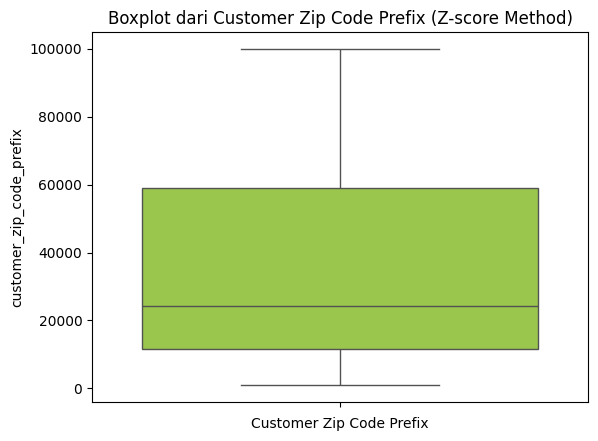

In [74]:
# Membuat boxplot
sns.boxplot(data=customer.customer_zip_code_prefix)
plt.title('Boxplot dari Customer Zip Code Prefix (Z-score Method)')
plt.xlabel('Customer Zip Code Prefix')
plt.show()


# ***Sellers***

In [75]:
# mendapatkan data seller
seller = pd.read_sql_query("""
                    SELECT
                        *
                    FROM Sellers
                  """, conn)
seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,8602a61d680a10a82cceeeda0d99ea3d,1001,sao paulo,SP
1,dd55f1bb788714a40e7954c3be6df745,1021,sao paulo,SP
2,e0487761face83d64fcada2408959a36,1021,sao paulo,SP
3,09bad886111255c5b5030314fc7f1a4a,1022,sao paulo,SP
4,f049a72cf58fd31b11f8919cade515e7,1023,sao paulo,SP


In [76]:
seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


Tidak ada type data yang perlu diganti dari tabel seller

**Missing Value**

In [77]:
# Cek kembali apakah masih terdapat missing value
pd.isnull(seller).sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Tidak Ada missing vlaue pada tabel seller

**Duplicate**

In [78]:
# Mengidentifikasi apakah terdapat duplicate value pada tabel dengan acuan kolom PassengerId
seller[seller["seller_id"].duplicated(keep=False)].sort_values("seller_id")

,seller_id,seller_zip_code_prefix,seller_city,seller_state


Tak ada duplicate data pada tabel seller

# ***Seller Outlier***

In [79]:
seller.describe()

,seller_zip_code_prefix
count,3095.000000
mean,32291.059451
std,32713.453830
min,1001.000000
25%,7093.500000
50%,14940.000000
75%,64552.500000
max,99730.000000


In [80]:
# Mendeteksi Outlier dengan Z-score
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers_zscore = detect_outliers_zscore(seller.seller_zip_code_prefix)
print("Outliers from Z-scores method: ", sample_outliers_zscore)

Outliers from Z-scores method:  []


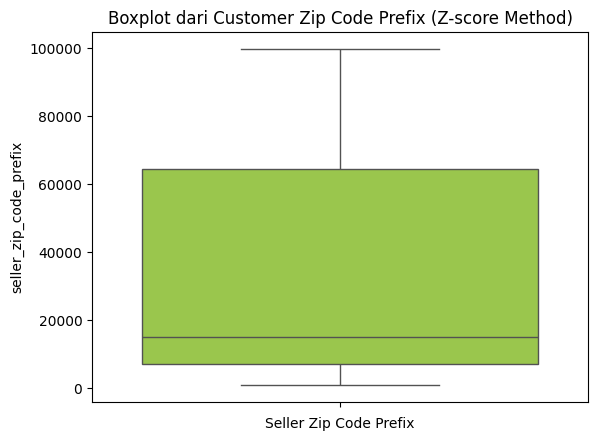

In [81]:
# Membuat boxplot
sns.boxplot(data=seller.seller_zip_code_prefix)
sns.set_palette("viridis_r")
plt.title('Boxplot dari Customer Zip Code Prefix (Z-score Method)')
plt.xlabel('Seller Zip Code Prefix')
plt.show()


Tidak ada Outlier pada tabel seller

# ***Geolocation***

In [82]:
# mendapatkan data geolocation
geolocation = pd.read_sql_query("""
                    SELECT
                        *
                    FROM Geolocation
                  """, conn)
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.549292,-46.633559
1,1012,-23.540451,-46.643570
2,1014,-23.542521,-46.635335
3,1020,-23.544207,-46.636281
4,1021,-23.546718,-46.639357


In [83]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7125 entries, 0 to 7124
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  7125 non-null   int64  
 1   geolocation_lat              7125 non-null   float64
 2   geolocation_lng              7125 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 167.1 KB


Type data pada tabel geolocation sudah benar jadi tidak ada yang perlu diganti

**Missing Value**

In [84]:
# Cek kembali apakah masih terdapat missing value
pd.isnull(geolocation).sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
dtype: int64

Tidak ada missing value pada tabel geolocation

**Duplicate**

In [85]:
# Mengidentifikasi apakah terdapat duplicate value pada tabel dengan acuan kolom PassengerId
geolocation[geolocation["geolocation_zip_code_prefix"].duplicated(keep=False)].sort_values("geolocation_zip_code_prefix")

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng


Tidak ada duplicate pada tabel geolocation

# ***Geolocation Outlier***

In [86]:
geolocation.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,7125.000000,7125.000000,7125.000000
mean,36204.116351,-21.210736,-46.431327
std,31303.218226,5.735644,4.280875
min,1001.000000,-33.528490,-69.567185
25%,8255.000000,-23.610773,-48.647936
50%,25770.000000,-22.924910,-46.637355
75%,65063.000000,-19.952436,-43.727535
max,99955.000000,2.832334,-34.827810


In [87]:
# Mendeteksi Outlier dengan Z-score
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers_zscore = detect_outliers_zscore(geolocation.geolocation_zip_code_prefix)
print("Outliers from Z-scores method: ", sample_outliers_zscore)

Outliers from Z-scores method:  []


In [88]:
# Mendeteksi Outlier dengan Z-score
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers_zscore = detect_outliers_zscore(geolocation.geolocation_lat)
print("Outliers from Z-scores method: ", sample_outliers_zscore)

Outliers from Z-scores method:  [-3.744871543712848, -3.738325358589649, -3.73649169713354, -3.735497399388312, -3.755962707744244, -3.732269374852301, -3.708945027259426, -3.7244936894223684, -3.7468381851232095, -3.717893972287516, -3.7299268184834657, -3.725555241853177, -3.719036598389977, -3.7164888112570766, -3.733489110190975, -3.70993881624134, -3.712342840412017, -3.731693819471136, -3.7301292084367232, -3.713395892867438, -3.725790516792654, -3.772861155394857, -3.770216747102858, -3.762952511800991, -3.7673842209302033, -3.775989332858129, -3.7752544546137057, -3.775637999999944, -3.796640853453757, -3.7841274428480656, -3.8376209999999444, -3.7779004016100113, -3.8223915298343965, -3.816478510098433, -3.818348947525205, -3.806575907653104, -3.800180682209018, -3.625824805463081, -3.891675749402051, -3.9706036552125687, -3.882962999999947, -3.7102242953371287, -3.5290105805078817, -3.773253644878456, -3.724761925997306, -3.0354238361363084, -2.8985169609408468, -2.9098355137

In [89]:
# Mendeteksi Outlier dengan Z-score
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers_zscore = detect_outliers_zscore(geolocation.geolocation_lng)
print("Outliers from Z-scores method: ", sample_outliers_zscore)

Outliers from Z-scores method:  [-63.90793314364332, -60.01436131543865, -60.026162437965276, -59.98960621357261, -59.94760853101134, -60.01748659503152, -59.97461231848346, -60.03930765583706, -60.002075462115535, -59.98022222630927, -60.04470612571284, -60.00565360857707, -59.95328175, -59.99021748214453, -60.003173462115534, -60.008812836700116, -60.0508215, -59.950260418403204, -60.70600869673317, -60.71801184013026, -60.723250555893706, -60.66787289515002, -60.75377568216231, -63.14599039919177, -66.09262861079429, -69.56718520987947, -67.80143293728644, -67.7961031902591, -67.82081885636795, -67.8189091486237, -67.81616366625309, -67.18848343155959, -67.85151076599993, -67.83086213406779, -67.78985768384965, -67.73558130063502, -67.77629459991907, -63.192090866499, -63.90062415726487, -63.906289540487116, -63.89118749893503, -63.82824457054834, -63.0292651498388, -63.04424245674391, -63.84050407515601, -63.89084606722406, -63.89813168960104, -63.82808089578236, -63.89064906901606

Mengatasi Outlier dengan Menggunakan pendekatan batas atas dan batas bawah

In [90]:
# Hitung kuartil pertama (Q1) dan kuartil ketiga (Q3)
Q1 = geolocation['geolocation_lat'].quantile(0.25)
Q3 = geolocation['geolocation_lat'].quantile(0.75)

# Hitung rentang interkuartil (IQR)
IQR = Q3 - Q1

# Tentukan batas bawah dan batas atas untuk menentukan outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Ganti nilai outlier dengan nilai kuartil
geolocation.loc[geolocation['geolocation_lat'] < lower_bound, 'geolocation_lat'] = Q1
geolocation.loc[geolocation['geolocation_lat'] > upper_bound, 'geolocation_lat'] = Q3

In [91]:
# Deteksi outlier dengan IQR
geolocation_lat_outliers = detect_outliers_iqr(list(geolocation.geolocation_lat))
print("Outliers from IQR method: ", geolocation_lat_outliers)

Outliers from IQR method:  []


In [92]:
# Hitung kuartil pertama (Q1) dan kuartil ketiga (Q3)
Q1 = geolocation['geolocation_lng'].quantile(0.25)
Q3 = geolocation['geolocation_lng'].quantile(0.75)

# Hitung rentang interkuartil (IQR)
IQR = Q3 - Q1

# Tentukan batas bawah dan batas atas untuk menentukan outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Ganti nilai outlier dengan nilai kuartil
geolocation.loc[geolocation['geolocation_lng'] < lower_bound, 'geolocation_lng'] = Q1
geolocation.loc[geolocation['geolocation_lng'] > upper_bound, 'geolocation_lng'] = Q3

In [93]:
# Deteksi outlier dengan IQR
geolocation_lng_outliers = detect_outliers_iqr(list(geolocation.geolocation_lng))
print("Outliers from IQR method: ", geolocation_lng_outliers)

Outliers from IQR method:  []


In [94]:
# Menyimpan data transaksi, produk, dan customer yang sudah bersih
order.to_csv(path + "order_cleaning.csv")
produk.to_csv(path + "produk_cleaning.csv")
customer.to_csv(path + "customer_cleaning.csv")
seller.to_csv(path + "seller_cleaning.csv")
geolocation.to_csv(path + "geolocation_cleaning.csv")

## 7. Exploratory Data Analysis & Visualization

Problem statemen
1. melakukan profiling agar mendapat customer yang lebih tertarget.
2. memberikan product recommendation untuk meningkatkan revenue
3. Mengoptimalisasi penggunaan payment agar lebih tertarget pada customer.

In [95]:
customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,3df704f53d3f1d4818840b34ec672a9f,04cf8185c71090d28baa4407b2e6d600,5271,sao paulo,SP
1,f5afca14dfa9dc64251cf2b45c54c363,38cad70d154a4dcc42b598d5c01f7ef1,25211,duque de caxias,RJ
2,be8c14c16a4d47194ccdfe10f1fc5b1a,c86a25b8f5f6c203bb3471553bdc3200,13157,cosmopolis,SP
3,388025bec8128ff20ec1a316ed4dcf02,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR
4,05e996469a2bf9559c7122b87e156724,5229b8e4d7d2b9b676c2083c17b1ecd0,93180,portao,RS


In [96]:
produk.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,72d3bf1d3a790f8874096fcf860e3eff,toys,57.0,341.00,2.0,583.0,20.0,21.0,20.0
1,60184212dae4e6b0da32bf54271a8c4a,watches_gifts,59.0,476.00,2.0,394.0,17.0,11.0,14.0
2,7564c1759c04fc0a38f2aa84f7a370ee,construction_tools_construction,59.0,1934.25,3.0,1200.0,16.0,11.0,11.0
3,a5a0e71a81ae65aa335e71c06261e260,housewares,57.0,698.00,3.0,705.0,34.0,22.0,28.0
4,69d980b4120a76616d7b237d731d6156,watches_gifts,60.0,1362.00,3.0,600.0,16.0,11.0,12.0


In [134]:
order

,index,order_id,customer_id,order_status,order_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score
0,0,432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,delivered,2018-03-01,2018-03-21,1.0,72d3bf1d3a790f8874096fcf860e3eff,0bae85eb84b9fb3bd773911e89288d54,2018-03-07 15:10:47,38.25,16.11000,1.0,credit_card,1.0,54.36,8f39f09c22b1ceb6e3eb178d8e50bb8a,4.0
1,1,641fb0752bf5b5940c376b3a8bb9dc52,f5afca14dfa9dc64251cf2b45c54c363,delivered,2017-12-15,2018-01-16,1.0,60184212dae4e6b0da32bf54271a8c4a,b33e7c55446eabf8fe1a42d037ac7d6d,2017-12-21 00:14:55,265.15,17.33000,1.0,credit_card,8.5,377.09,ffa0d9ba2678dba5fa370295245f473d,4.0
2,2,b52cc4919de82b4d696a4380d10804a3,be8c14c16a4d47194ccdfe10f1fc5b1a,delivered,2018-06-13,2018-06-26,1.0,7564c1759c04fc0a38f2aa84f7a370ee,6860153b69cc696d5dcfe1cdaaafcf62,2018-06-19 02:30:26,42.99,12.03000,1.0,boleto,1.0,55.02,b1dafcdfcddb6feb75222b9c1f2baad3,5.0
3,3,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20,2017-05-12,1.0,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56000,1.0,boleto,1.0,267.80,fd793fea4f4a2ddcc956561144b6c04e,2.5
4,5,634e8f4c0f6744a626f77f39770ac6aa,05e996469a2bf9559c7122b87e156724,delivered,2017-08-09,2017-08-31,1.0,69d980b4120a76616d7b237d731d6156,744dac408745240a2c2528fb1b6028f3,2017-08-15 18:45:18,219.00,15.28000,1.0,credit_card,1.0,7.08,7b66de927426b71a817aa36df5e8a0b3,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10637,10996,1b4a0e6b19d0034b531655b41ea89623,ce5efd1b1d8a2fa290a871edd5c26cd6,delivered,2017-10-02,2017-10-24,1.0,9e10ae46a3021a02f1692448ef9fa1db,8b28d096634035667e8263d57ba3368c,2017-10-06 08:56:53,37.90,11.85000,1.0,credit_card,4.0,49.75,47697b20bcd3995f870e284fad248ac8,4.0
10638,10997,dfc6eb45a2753ed9e6c6ef4987b44503,a046c690e0564ffde0ce611b5eee2c30,delivered,2018-05-25,2018-06-26,1.0,829002c1d5f40820ebbc6ecd4bcdf3ab,1025f0e2d44d7041d6cf58b6550e0bfa,2018-05-30 17:15:21,150.00,23.63000,1.0,credit_card,4.0,173.63,22503643d52782c09b5151c634233e34,5.0
10639,10998,6ec4642f9993cc34f826cfb9068e5a2f,f00bb12620b7b232233cace1b229db18,delivered,2017-11-21,2017-12-08,1.0,9503faef00966962beacdb4916272305,b2ba3715d723d245138f291a6fe42594,2017-11-27 20:28:22,265.15,19.35000,1.0,credit_card,7.0,319.25,d76f6d4e5f6adbc77ec42f047ad47dc7,4.0
10640,10999,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04,2017-11-07,1.0,49d2e2460386273b195e7e59b43587c3,1caf283236cd69af44cbc09a0a1e7d32,2017-10-10 20:07:14,26.90,33.76875,1.0,credit_card,2.0,42.42,ebd75732b5804e934123d11ec1f11db0,5.0


In [98]:
seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,8602a61d680a10a82cceeeda0d99ea3d,1001,sao paulo,SP
1,dd55f1bb788714a40e7954c3be6df745,1021,sao paulo,SP
2,e0487761face83d64fcada2408959a36,1021,sao paulo,SP
3,09bad886111255c5b5030314fc7f1a4a,1022,sao paulo,SP
4,f049a72cf58fd31b11f8919cade515e7,1023,sao paulo,SP


In [99]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.549292,-46.633559
1,1012,-23.540451,-46.643570
2,1014,-23.542521,-46.635335
3,1020,-23.544207,-46.636281
4,1021,-23.546718,-46.639357


## **Profil Customer yang paling banyak melakukan pembelian terletak pada Kota ?**

In [100]:
# Buat kolom baru untuk nama kota yang hanya berisi nama kota tanpa kode pos
customer["city"] = customer["customer_city"].str.split().str[0]

# Hitung jumlah customer per kota
customer_city_counts = customer["city"].value_counts().reset_index(name="Jumlah Customer")

# Urutkan data berdasarkan jumlah customer dari terbanyak ke terkecil
customer_city_counts_sorted = customer_city_counts.sort_values(by=["Jumlah Customer"], ascending=False)

# Tampilkan 5 kota teratas dengan customer terbanyak
print("5 Kota dengan Paling Banyak Customer:")
print(customer_city_counts_sorted.head(5))

5 Kota dengan Paling Banyak Customer:
       city  Jumlah Customer
0       sao             2257
1       rio              851
2      belo              290
3  brasilia              223
4     porto              165


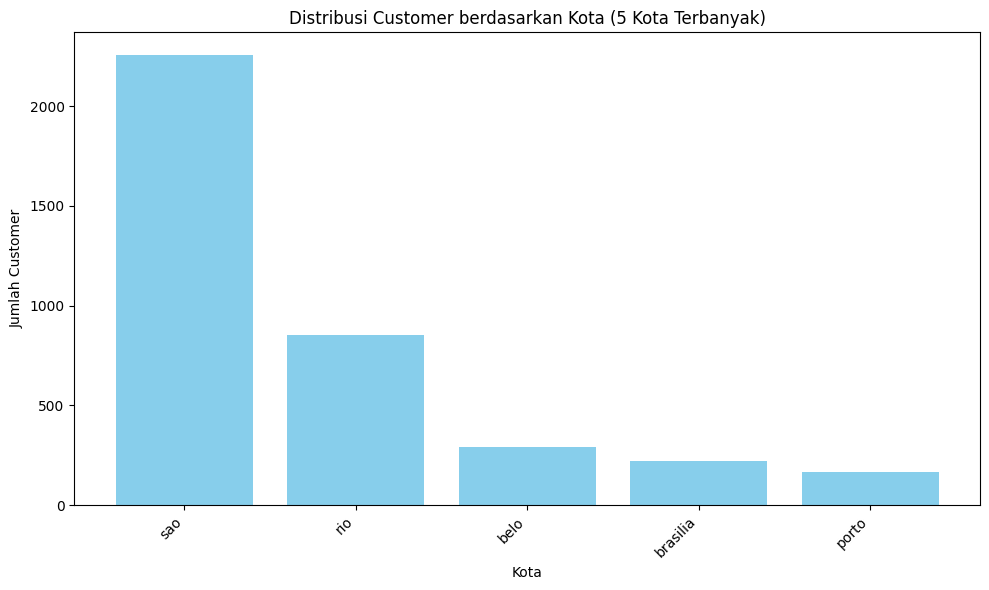

In [101]:
# Data from the provided output
cities = ['sao', 'rio', 'belo', 'brasilia', 'porto']
customer_counts = [2257, 851, 290, 223, 165]
plt.figure(figsize=(10, 6))
plt.bar(cities, customer_counts, color='skyblue')
plt.xlabel('Kota')
plt.ylabel('Jumlah Customer')
plt.title('Distribusi Customer berdasarkan Kota (5 Kota Terbanyak)')
plt.xticks(rotation=45, ha='right')  # Rotate city labels for better readability
plt.tight_layout()
plt.show()

### Profil Customer yang paling banyak melakukan pembelian ada pada kota **SAO PAULO**

## **Kategori Produk Yang Paling Laris terjual**

In [136]:
# Count Product Occurrences and Get Top 5
product_sales_count = order["product_id"].value_counts().reset_index(name="Jumlah Penjualan").sort_values(by=["Jumlah Penjualan"], ascending=False).head(5)
product_ids_top_5 = product_sales_count["product_id"].tolist()

# Merge Data for Product Names and Category
merged_data = produk.merge(product_sales_count, on='product_id', how='left')

# Get Top 5 Product Information
top_5_products = merged_data[merged_data['product_id'].isin(product_ids_top_5)]

# Extract Category Names
category_names = top_5_products["product_category_name"].tolist()

# Print Results
for i in range(len(product_ids_top_5)):
  print(f"Produk ID: {product_ids_top_5[i]} - (Kategori: {category_names[i]})")

Produk ID: 99a4788cb24856965c36a24e339b6058 - (Kategori: bed_bath_table)
Produk ID: 422879e10f46682990de24d770e7f83d - (Kategori: garden_tools)
Produk ID: aca2eb7d00ea1a7b8ebd4e68314663af - (Kategori: furniture_decor)
Produk ID: 53759a2ecddad2bb87a079a1f1519f73 - (Kategori: garden_tools)
Produk ID: 368c6c730842d78016ad823897a372db - (Kategori: garden_tools)


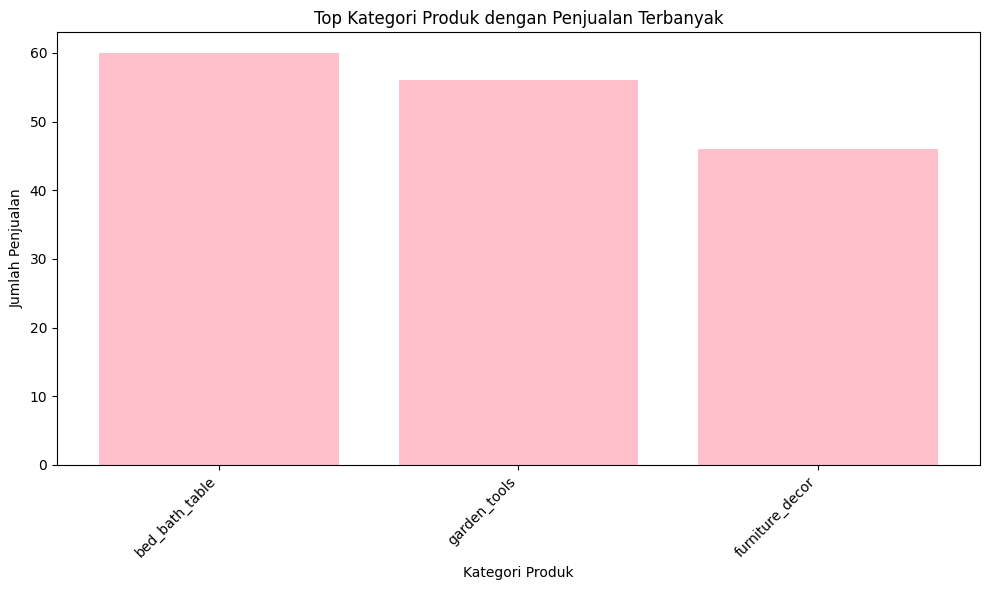

In [132]:
# Create Bar Chart (Top 5 Categories)
plt.figure(figsize=(10, 6))
plt.bar(category_names, product_sales_count["Jumlah Penjualan"], color='pink')  # Use category names on x-axis
plt.xlabel('Kategori Produk')
plt.ylabel('Jumlah Penjualan')
plt.title('Top Kategori Produk dengan Penjualan Terbanyak')
plt.xticks(rotation=45, ha='right')  # Rotate category names for better readability
plt.tight_layout()
plt.show()

## **Kategori Produk Dengan Pendapatan Tertinggi**

In [140]:
# Gabungkan Tabel Produk dan Order
merged_data = pd.merge(order, produk, on='product_id', how='inner')

In [141]:
# Analisis Produk dengan Pendapatan Tinggi
high_revenue_products = merged_data.groupby('product_id')['price'].sum().sort_values(ascending=False).head(5)
high_revenue_products

product_id
6cdd53843498f92890544667809f1595    6098.45
99a4788cb24856965c36a24e339b6058    5283.60
d1c427060a0f73f6b889a5c7c61f2ac4    4382.85
53b36df67ebb7c41585e8d54d6772e08    3728.59
3dd2a17168ec895c781a9191c1e95ad7    3597.60
Name: price, dtype: float64

In [142]:
# Pilih Kolom yang Dibutuhkan
output = merged_data[['product_id', 'product_category_name']]
output

,product_id,product_category_name
0,72d3bf1d3a790f8874096fcf860e3eff,toys
1,72d3bf1d3a790f8874096fcf860e3eff,toys
2,60184212dae4e6b0da32bf54271a8c4a,watches_gifts
3,7564c1759c04fc0a38f2aa84f7a370ee,construction_tools_construction
4,7564c1759c04fc0a38f2aa84f7a370ee,construction_tools_construction
...,...,...
10637,526f833e1eb0a32ad9351145a761b9ab,watches_gifts
10638,9e10ae46a3021a02f1692448ef9fa1db,health_beauty
10639,829002c1d5f40820ebbc6ecd4bcdf3ab,home_construction
10640,9503faef00966962beacdb4916272305,construction_tools_construction


**Produk yang memiliki price tertinggi memiliki kode id produk : 6cdd53843498f92890544667809f1595. Yang termasuk dalam kategori health_beauty**

## **Produk yang memiliki pendapatan tertinggi memiliki kode id produk : 99a4788cb24856965c36a24e339b6058. Yang termasuk dalam kategori bed_bath_table**

In [ ]:
# Reset index to convert Series to DataFrame for merging
top_products = top_products.reset_index(name='count')

# Combine DataFrames
high_revenue_with_high_purchase = pd.merge(high_revenue_products, top_products, how='inner', on='product_id')


In [ ]:
high_revenue_with_high_purchase

,product_id,price,count
0,99a4788cb24856965c36a24e339b6058,5283.6,60


### Produk recomendasi Yang memiliki Penjualan terbanyak dan Harga Tertinggi dengan Product_Id : 99a4788cb24856965c36a24e339b6058, dan masuk dalam Kategori produk **bed_bath_table**

## **Table jumlah transaksi harian

In [ ]:
# Langkah 1. Mengelompokkan transaksi berdasarkan tanggal
data_harian = order.groupby('order_date')['customer_id'].size()
data_harian

order_date
2016-09-05    1
2016-10-03    1
2016-10-04    5
2016-10-05    5
2016-10-06    7
             ..
2018-08-25    6
2018-08-26    9
2018-08-27    8
2018-08-28    5
2018-08-29    3
Name: customer_id, Length: 607, dtype: int64

In [ ]:
# Group by Order Date and Count Unique Customers
highest_customer_dates = order.groupby('order_date')['customer_id'].size().sort_values(ascending=False)
# Print the Results (optional)
print(highest_customer_dates)

order_date
2017-11-24    141
2017-11-25     57
2018-08-07     48
2018-08-02     46
2018-05-14     45
             ... 
2017-01-10      1
2017-01-11      1
2017-01-12      1
2017-01-15      1
2016-09-05      1
Name: customer_id, Length: 607, dtype: int64


In [ ]:
data_harian = data_harian.reset_index()
data_harian.rename(columns={'customer_id':'jumlah customer'},inplace=True)
data_harian

,index,order_date,jumlah customer
0,0,2016-09-05,1
1,1,2016-10-03,1
2,2,2016-10-04,5
3,3,2016-10-05,5
4,4,2016-10-06,7
...,...,...,...
602,602,2018-08-25,6
603,603,2018-08-26,9
604,604,2018-08-27,8
605,605,2018-08-28,5


In [ ]:
# Cek tipe data
data_harian.dtypes

index               int64
order_date         object
jumlah customer     int64
dtype: object

## **Grafik Penjualan setiap hari**

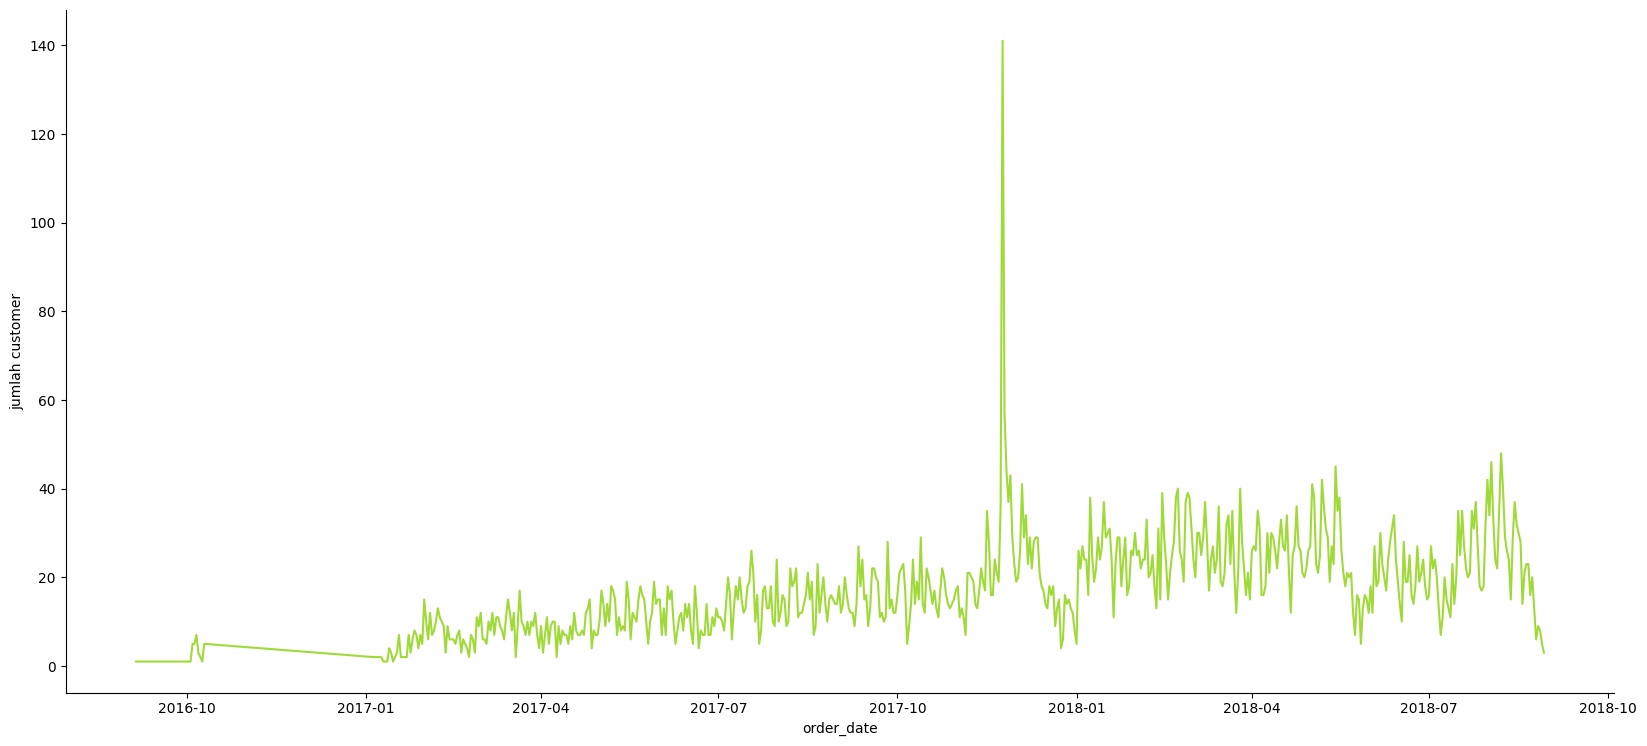

In [ ]:
# Plot
g=sns.relplot(x="order_date", y="jumlah customer", kind="line", data=data_harian)
g.fig.set_size_inches(20,8)

## **Metode Payment yang paling sering digunakan oleh customer**

In [ ]:
order.head()

,index,order_id,customer_id,order_status,order_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score
0,0,432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,delivered,2018-03-01,2018-03-21,1.0,72d3bf1d3a790f8874096fcf860e3eff,0bae85eb84b9fb3bd773911e89288d54,2018-03-07 15:10:47,38.25,16.11,1.0,credit_card,1.0,54.36,8f39f09c22b1ceb6e3eb178d8e50bb8a,4.0
1,1,641fb0752bf5b5940c376b3a8bb9dc52,f5afca14dfa9dc64251cf2b45c54c363,delivered,2017-12-15,2018-01-16,1.0,60184212dae4e6b0da32bf54271a8c4a,b33e7c55446eabf8fe1a42d037ac7d6d,2017-12-21 00:14:55,265.15,17.33,1.0,credit_card,8.5,377.09,ffa0d9ba2678dba5fa370295245f473d,4.0
2,2,b52cc4919de82b4d696a4380d10804a3,be8c14c16a4d47194ccdfe10f1fc5b1a,delivered,2018-06-13,2018-06-26,1.0,7564c1759c04fc0a38f2aa84f7a370ee,6860153b69cc696d5dcfe1cdaaafcf62,2018-06-19 02:30:26,42.99,12.03,1.0,boleto,1.0,55.02,b1dafcdfcddb6feb75222b9c1f2baad3,5.0
3,3,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20,2017-05-12,1.0,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,1.0,boleto,1.0,267.80,fd793fea4f4a2ddcc956561144b6c04e,2.5
4,5,634e8f4c0f6744a626f77f39770ac6aa,05e996469a2bf9559c7122b87e156724,delivered,2017-08-09,2017-08-31,1.0,69d980b4120a76616d7b237d731d6156,744dac408745240a2c2528fb1b6028f3,2017-08-15 18:45:18,219.00,15.28,1.0,credit_card,1.0,7.08,7b66de927426b71a817aa36df5e8a0b3,2.5


In [ ]:
# Pilih kolom yang diinginkan
payment = ["payment_sequential", "payment_type", "payment_value"]
payments = order[payment]
payments

,payment_sequential,payment_type,payment_value
0,1.0,credit_card,54.36
1,1.0,credit_card,377.09
2,1.0,boleto,55.02
3,1.0,boleto,267.80
4,1.0,credit_card,7.08
...,...,...,...
10637,1.0,credit_card,49.75
10638,1.0,credit_card,173.63
10639,1.0,credit_card,319.25
10640,1.0,credit_card,42.42


In [ ]:
# Group berdasarkan "payment_type" (atau kolom lain untuk analisis berbeda)
pembayaran_dikelompokkan = payments.groupby("payment_type")
pembayaran_dikelompokkan.describe()

payment_sequential                                     \
                          count mean  std  min  25%  50%  75%  max   
payment_type                                                         
boleto                   2058.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
credit_card              7896.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
debit_card                162.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
voucher                   526.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   

             payment_value                                                  \
                     count        mean         std    min     25%      50%   
payment_type                                                                 
boleto              2058.0  136.546443  101.446777  13.78  58.145  104.595   
credit_card         7896.0  145.923894  104.606685   0.03  65.000  114.790   
debit_card           162.0  126.316790   95.657370  20.06  53.025  101.380   
voucher              526.0   63.923840   63.979538   0.22  20.000   49.435   

                                
                   75%     max  
payment_type                    
boleto        183.9025  377.09  
credit_card   194.1650  377.09  
debit_card    170.1975  377.09  
voucher        86.8375  377.09

In [ ]:
# Segment customers based on payment type and average order value
customer_segments = payments.groupby("payment_type")["payment_value"].mean()
customer_segments

payment_type
boleto         136.546443
credit_card    145.923894
debit_card     126.316790
voucher         63.923840
Name: payment_value, dtype: float64

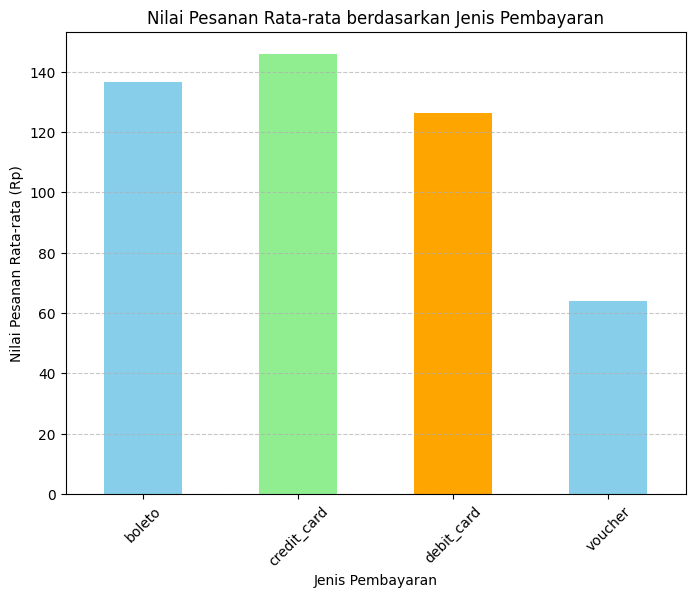

In [ ]:
# Siapkan plot
plt.figure(figsize=(8, 6))
customer_segments.plot(kind="bar", color=['skyblue', 'lightgreen', 'orange'])  # Sesuaikan warna

# Label sumbu dan judul
plt.xlabel("Jenis Pembayaran")
plt.ylabel("Nilai Pesanan Rata-rata (Rp)")
plt.title("Nilai Pesanan Rata-rata berdasarkan Jenis Pembayaran")

# Rotasi label sumbu x untuk tampilan yang lebih baik (opsional)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Tambahkan garis grid (opsional)

# Tampilkan plot
plt.show()

**Rata - Rata Customer Melakukan Order paling Banyak dengan menggunakan Metode Payment credit_card atau Kartu Kredit**

# **Status Order Setiap Tahun**

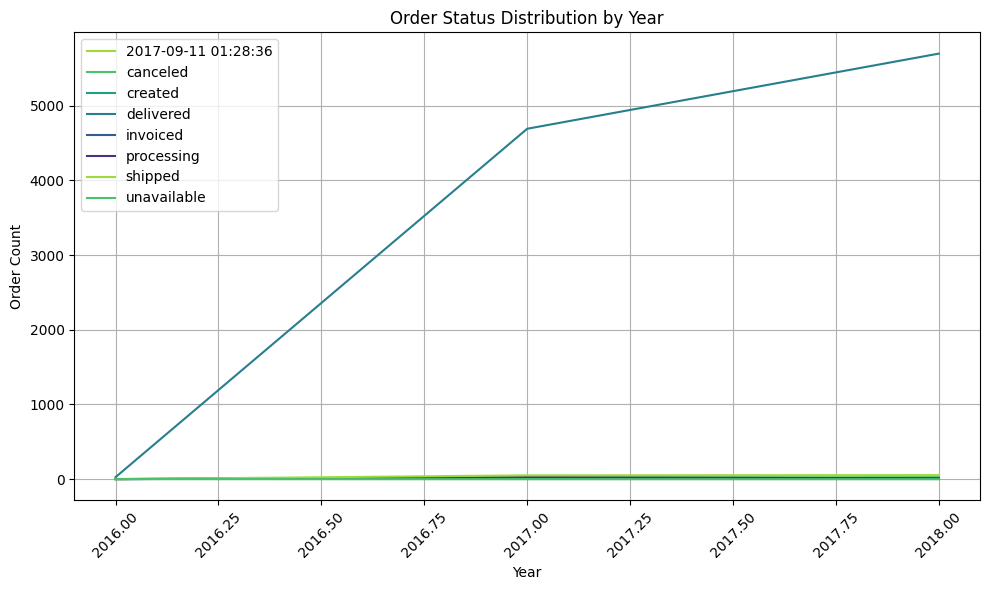

 year most_frequent_status
 2016            delivered
 2017            delivered
 2018            delivered


In [143]:
# Extract year from order_date
order['year'] = pd.to_datetime(order['order_date']).dt.year

# Group by year and count occurrences of each order_status
status_per_year = order.groupby(['year', 'order_status'])['order_id'].count().unstack(fill_value=0)

# Find the most frequent order status for each year (across rows)
most_frequent_status = status_per_year.idxmax(axis=1)

# Combine year and most frequent status into a DataFrame
results = pd.DataFrame({'year': most_frequent_status.index, 'most_frequent_status': most_frequent_status.values})

# Create line chart
plt.figure(figsize=(10, 6))  # Adjust figure size as desired

for col in status_per_year.columns:
    plt.plot(status_per_year.index, status_per_year[col], label=col)

plt.xlabel('Year')
plt.ylabel('Order Count')
plt.title('Order Status Distribution by Year')
plt.legend()
plt.grid(True)

# Optional: Rotate x-axis labels for readability if many years
plt.xticks(rotation=45)  # Uncomment if needed

plt.tight_layout()
plt.show()

# Print results (showing most frequent status_order for each year)
print(results.to_string(index=False))

**Delivered adalah status order terbanyak setiap tahunnya**

# **Rata - rata Score Review  customer Terbanyak**

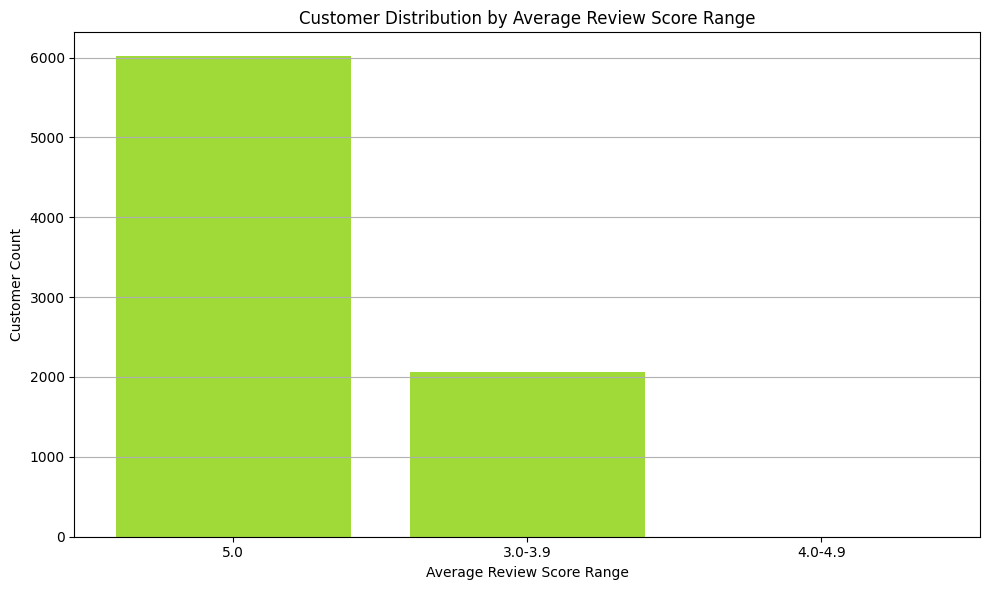

In [149]:
# Group by customer_id and calculate average review score
average_scores = order.groupby('customer_id')['review_score'].mean().reset_index()

average_scores['score_range'] = pd.cut(average_scores['review_score'], bins=[3, 4, 4.9, 5], labels=['3.0-3.9', '4.0-4.9', '5.0'])

# Count customers in each score range
customer_counts = average_scores['score_range'].value_counts().reset_index()
customer_counts.columns = ['score_range', 'customer_count']

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(customer_counts['score_range'], customer_counts['customer_count'])
plt.xlabel('Average Review Score Range')
plt.ylabel('Customer Count')
plt.title('Customer Distribution by Average Review Score Range')
plt.grid(axis='y')

# Display bar chart
plt.tight_layout()
plt.show()

**Rata - rata score review customer sudah sangat baik yaitu 5.0**

# 8. Rekomendasi

1.   Perusahaan bisa menambah gudang terdekat didaerah kota Sao Paulo, yang dimana untuk mengantisipasi lonjakan pelanggan di kota tersebut , karena diketahui customer paling banyak bertempat tinggal di kota Sao Paulo.
2.   Untuk meningkatkan revenue perusahaan dapat meningkatkan penjualan kategori produk yang memiliki nilai tinggi dan paling laris dijual seperti kategori produk bed_bath_table, atau meningkatkan branding untuk produk dengan harga jual tinggi seperti kategori produk health_beauty
3.  Optimalisasi agar lebih tertarget pada kenyamanan customer perusahaan dapat menggunakan credit_card yang paling sering digunakan untuk pembelian.
4. Perusahaan dapat terus mempertahankan kestabilan pengiriman barang setiap customer yang sudah ada dengan terus memperhatikan status delivered setiap pesanan customer.
5. Perusahan dapat terus mempertahankan nilai sempurna kepada pelanggan dari review customer yang diberikan terhadap setiap pembelian, dan meningkatkan pelayanan kepada kategori produk yang memiliki review score kurang dari 4.0


## 9. Kesimpulan - Create the story

1.   Profiling Customer Paling Banyak ada pada kota Sao Paulo
2.   bed_bath_table adalah produk yang memiliki penjualan paling banyak dan price yang tinggi.
3.   Type Payment yang paling dominan dan paling sering digunakan oleh customer dari mulai tahun 2016 sampak 2018 adalah type payment credit_card.
4. Setiap tahunnya status order customer sudah sangat baik, dengan kebanyakan status barang yang dikirim adalah delivered atau barang sudah diterima oleh customer.
5. Score review yang diberikan oleh customer untuk setiap pembelian yang dilakukan di Oilist E-Commerce sudah sangat sempurna dengan kebanyaka customer memberikan nilai 5.0.